# Predict "Hoax" With Logistic Regression

Author: Steven Bhardwaj  
Date: Jan 10, 2022

*Note: Click on the* ⏵/⏷ *triangles in the left-margin to expand/collapse sections.*

### Abstract

In this notebook, I replicate a portion of the "Wiki-Reliability" [paper](https://dl.acm.org/doi/abs/10.1145/3404835.3463253) (by Wong et al.).   Using the [dataset](https://figshare.com/articles/dataset/Wiki-Reliability_A_Large_Scale_Dataset_for_Content_Reliability_on_Wikipedia/14113799) of engineered features and target labels provided by the authors, I predict classification of "hoax" articles. I apply SFFS/SFBS from Python library mlxtend for feature selection, and logistic regression from scikit-learn with a gridsearched ridge penalty. The resulting test score improves on the authors' logistic regression score versus their feature set chosen by feature importance.

### Original paper by Wong et al.

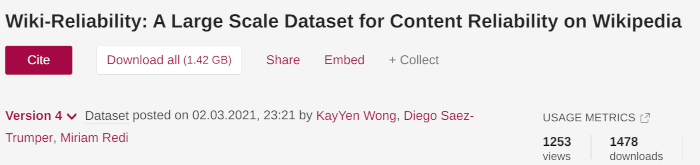  
([paper](https://dl.acm.org/doi/abs/10.1145/3404835.3463253)) ([data](https://figshare.com/articles/dataset/Wiki-Reliability_A_Large_Scale_Dataset_for_Content_Reliability_on_Wikipedia/14113799))

# Calculations

## Get hoax data

### imports

In [1]:
import os, re, patsy
import pandas as pd, numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
path = '/home/bhrdwj/git/predwikt/'
raw_path = path + 'data/raw/wiki_reliability/unzipped/'

In [2]:
feature_data_raw = (pd.read_csv(raw_path+'hoax_features.csv', usecols=lambda x: x not in ['Unnamed: 0'])
       .rename(columns={'headings_by_level(2)':'headings_by_level_2', 'revision_id.key':'revision_id_key'}))

### train test split

- Dataset has paired observations: one for positive and one for negative for particular articles.
- Train-test-split needs to keep paired observations in the same splits, for useful training to happen 

#### Organize paired data by making **indexing series**

- Indexing series ≡
    - index: revision_id
    - value: revision_id_key
- Make indexing series for both:
    - hoaxes: positive
    - not hoaxes: negative

In [3]:
feature_data_raw.has_template.value_counts()

1.0    1398
0.0    1390
Name: has_template, dtype: int64

- Note there are eight excess observations of positive (hoax) revs:
    - therefore, perform train-test split based on non-hoax first,
    - then use indices of that split to split hoaxes accordingly

In [4]:
df = feature_data_raw[['revision_id', 'revision_id_key', 'has_template']]
revid_ser_neg = df.copy().loc[df.has_template==0].set_index('revision_id')['revision_id_key']
revid_ser_pos = df.copy().loc[df.has_template==1].set_index('revision_id')['revision_id_key']
del df

#### Train-test split

Split the negative revids (indices)  
Get positive indices from revision_id_key (values)

In [5]:
revid_neg_tr, revid_neg_te = train_test_split(revid_ser_neg, test_size=.2, random_state=0)
revid_pos_tr = revid_ser_pos.loc[revid_neg_tr.values]
revid_pos_te = revid_ser_pos.loc[revid_neg_te.values]

Reconcatenate neg and pos observations into train and test revision_id indices

In [6]:
revid_tr = pd.concat((revid_pos_tr, revid_neg_tr))
revid_te = pd.concat((revid_pos_te, revid_neg_te))

Select original dataset into train and test using revision_id

In [7]:
fea_revid = feature_data_raw.set_index('revision_id')
dftr = fea_revid.loc[revid_tr.index].dropna()
dfte = fea_revid.loc[revid_te.index].dropna()

Clean namespace and view data summary

In [8]:
del revid_ser_neg, revid_ser_pos
del revid_neg_tr, revid_neg_te, revid_pos_tr, revid_pos_te
del revid_tr, revid_te, fea_revid

In [9]:
dftr[dftr.columns.difference(['page_id','revision_id_key','has_template'])].describe().T.sort_values(by='mean');

### prep

##### Separate X and y, remove non-features, onehotify categoricals

In [10]:
ytr = dftr.has_template
Xtr = dftr[dftr.columns.difference(['page_id','revision_id_key','has_template'])]
Xtr = patsy.dmatrix('~ '+' + '.join(Xtr.columns), data=Xtr, NA_action='drop', return_type='dataframe')

yte = dfte.has_template
Xte = dfte[dfte.columns.difference(['page_id','revision_id_key','has_template'])]
Xte = patsy.dmatrix('~ '+' + '.join(Xte.columns), data=Xte, NA_action='drop', return_type='dataframe')

##### Make complete list of features in case the test (or train) set doesn't include any of a rare class

In [11]:
Xcols = list(
    set(Xtr.columns.tolist())
    .union(set(Xte.columns.tolist()))
)

for col in Xcols:
    if col not in Xte:
        Xte[col] = 0
    if col not in Xtr:
        Xtr[col] = 0

##### Reindex with the complete feature list

In [12]:
Xtr = Xtr.reindex(columns=Xcols)
Xte = Xte.reindex(columns=Xcols)
Xtr.shape, Xte.shape

((2221, 25), (556, 25))

## Fit model

### imports

In [13]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### gridsearch function

In [14]:
def bh_sfs_gridsearch(Xtr, ytr, pipe, param_grid:dict):
    """
    Concept:
        Like sklearn's GridSearch, but relying on sfs for cross-validation.
        Returns all feature sets and cv scores from SFFS and SFBS runs and sub-runs for each params combo.
        (sklearn's GridSearch only returns model outputs from its winning param combo)
    Args:
        Xtr: pd.DataFrame of features
        ytr: pd.Series target
        pipe: sklearn Pipeline ending in a mlxtend SequentialFeatureSelector instance.
        param_grid: dict of lists, params of pipe, input for sklearn ParameterGrid
    Returns:
        dict:
        - keys are numbers starting in 1, for each cell of ParameterGrid
        - values are lists of feature names
    """
    print(f'start time: {dt.now()}')
    pg = {i:j for i,j in enumerate(ParameterGrid(param_grid), start=1)}
    sfs_featdict = {}
    sfs_scoredict = {}
    for i in pg:
        pipe.set_params(**pg[i]).fit(Xtr, ytr)
        k_feats = pg[i]['sfs__k_features']
        idx_tup = pipe.steps[-1][1].get_metric_dict()[k_feats]['feature_idx']
        
        d = {k:list(v['feature_idx']) for k,v in pipe.steps[1][1].subsets_.items()}  # IMPROVEMENT: change pipe.steps[1] to directly look for the sfs step
        for j in d: d[j] = Xtr.columns[d[j]]
        sfs_featdict[i] = d
        
        s = {k:v['avg_score'] for k,v in pipe.steps[1][1].subsets_.items()} # IMPROVEMENT: change pipe.steps[1] to directly look for the sfs step
        sfs_scoredict[i] = s
    print(f'finish time: {dt.now()}')
    return sfs_featdict, sfs_scoredict

### instances

In [15]:
scaler = StandardScaler()
lr_sfs = LogisticRegression(penalty='l2', max_iter=1000, fit_intercept=True)
cv_sfs = StratifiedKFold(n_splits=5, shuffle=False)
sfs = SFS(estimator=lr_sfs, forward=True, floating=False, scoring='accuracy', cv=cv_sfs) # unused / placeholder
sffs = SFS(estimator=lr_sfs, forward=True, floating=True, scoring='accuracy', cv=cv_sfs)
sfbs = SFS(estimator=lr_sfs, forward=False, floating=True, scoring='accuracy', cv=cv_sfs)
sfs_pipe = Pipeline([('scaler', scaler),('sfs', sfs)])

### fit

#### sffs

In [16]:
sfs_pipe_param_grid = {
    'sfs': [sffs, sfbs],
    'sfs__k_features': [1, len(Xtr.columns)],
    'sfs__estimator': [lr_sfs],
    'sfs__estimator__C': [.016]
}

# sfs_featdict, sfs_scoredict = bh_sfs_gridsearch(Xtr, ytr, sfs_pipe, sfs_pipe_param_grid)

#### pickle

In [17]:
import pickle

# with open(path+'data/processed/sfs_featdict.pickle','wb+') as f:
#     pickle.dump(sfs_featdict, f)
# with open(path+'data/processed/sfs_scoredict.pickle','wb+') as f:
#     pickle.dump(sfs_scoredict, f)

with open(path+'data/processed/sfs_featdict.pickle','rb') as f:
    sfs_featdict = pickle.load(f)
with open(path+'data/processed/sfs_scoredict.pickle','rb') as f:
    sfs_scoredict = pickle.load(f)

### extract feats

#### get onehot df ~ features selected by sfs

##### munge_onehotdf_from_sfs_featdict (function)

In [18]:
def munge_onehotdf_from_sfs_featdict(sfs_featdict):
    
    # simple 1D list of sfs  feats
    sfs_feat_set = set()
    for i in sfs_featdict:              # runs
        for j in sfs_featdict[i]:       # kfeats
            sfs_feats = list(sfs_feat_set.union(set(sfs_featdict[i][j])))
    
    # make multiindex columns and empty dataframe
    col = pd.MultiIndex.from_tuples(
        [(j,k) for j in sfs_featdict for k in sfs_featdict[j]])
    idx = pd.Index(sfs_feats, name='feature')
    df = pd.DataFrame('-', idx, col)
    
    # insert onehots into df
    for i in sfs_feats:                           # feats
        for j in sfs_featdict:                        # runs
            for k in sfs_featdict[j]:             # steps within run
                df.loc[i,(j,k)] = int(i in sfs_featdict[j][k])
    
    df = df.astype(int) 
    return df

##### get df

In [19]:
sfs_onehots = munge_onehotdf_from_sfs_featdict(sfs_featdict)

#### get simple 1D lists of sfs runs, kfeats, and feats

In [20]:
sfs_runs = list(sfs_featdict.keys())

sfs_feat_set, sfs_kfeats_set = set(), set()
for i in sfs_featdict:              # runs
    for j in sfs_featdict[i]:       # kfeats
        sfs_feats = list(sfs_feat_set.union(set(sfs_featdict[i][j])))
        sfs_kfeats = list(sfs_kfeats_set.union(set([j])))

#### sort the index of features by occurence

##### count occurrences of features to sort the index

In [21]:
idx = pd.IndexSlice
sfs_feat_usecounts = sfs_onehots.loc[:,idx[1,:]].sum(axis=1)
for i in sfs_featdict:
    sfs_feat_usecounts += sfs_onehots.loc[:,idx[i,:]].sum(axis=1)

##### sort features by frequency of occurence in sfs cases

In [22]:
sfs_onehots = sfs_onehots.reindex(index=sfs_feat_usecounts.sort_values(ascending=False).index)
sfs_onehots = sfs_onehots.sort_index(axis=1)

### viz feats

#### imports

In [23]:
import matplotlib
%matplotlib inline
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import seaborn as sns

#### plot feature selection

In [24]:
feat_fig, ax = plt.subplots(1,2, figsize=(16,8))
feat_fig.subplots_adjust(wspace=.5)

(sns.heatmap(
    sfs_onehots.loc[:,idx[2,:]].T.droplevel(level=0).T, 
    ax=ax[0], cbar=False)
    .set(ylabel=None, xlabel='kfeats')   
)
(sns.heatmap(
    sfs_onehots.loc[:,idx[3,:]].T.droplevel(level=0).T, 
    ax=ax[1], cbar=False)
    .set(ylabel=None, xlabel='kfeats')
)

ax[0].set_title('Sequential Floating Forward Selection')
ax[1].set_title('Sequential Floating Backward Selection')
feat_fig.suptitle('Logistic Regression: Features selected, graphed against k_features')
feat_fig.show()

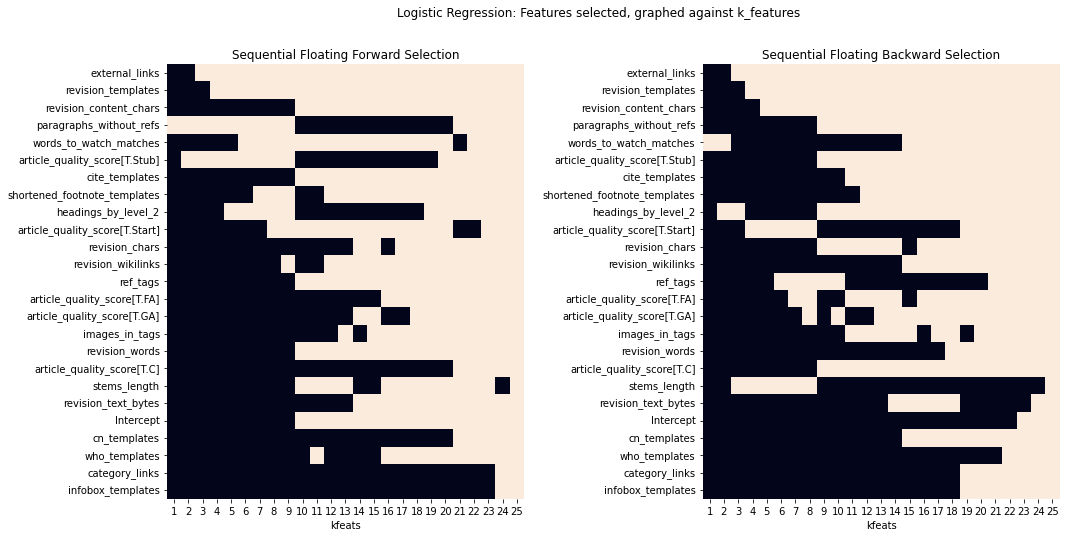

In [25]:
feat_fig

### identify best set of feats

#### create empty dataframe for scores

In [26]:
df_scores = pd.DataFrame('-', ['score'], sfs_onehots.columns)

#### insert scores into dataframe

In [27]:
for j in sfs_runs:                        # runs
    for k in sfs_featdict[j]:             # steps within run
        df_scores.loc['score',(j,k)] = sfs_scoredict[j][k]   
df_scores = df_scores.sort_index(axis=1)

#### select the multiindex that had the best cross-val score across sffs and sfbs

In [28]:
cols_best_index = df_scores.T.astype(float).nlargest(1, columns='score').T.columns
kfeats_best = list(cols_best_index)[0][1]
sfs_feats_best_onehots = sfs_onehots[cols_best_index].T.droplevel(level=0).reset_index(drop=True).T
sfs_feats_best = sfs_feats_best_onehots[(sfs_feats_best_onehots > 0).values].index.tolist()
sfs_score_best = df_scores.T.astype(float).nlargest(1, columns='score').values[0][0]

In [29]:
kfeats_best, sfs_score_best, sfs_feats_best

(10,
 0.6271910112359551,
 ['external_links',
  'revision_templates',
  'revision_content_chars',
  'words_to_watch_matches',
  'cite_templates',
  'article_quality_score[T.Start]',
  'ref_tags',
  'revision_words',
  'stems_length',
  'Intercept'])

#### plot cv scores from feature selection

In [30]:
scor_fig, ax = plt.subplots(1,2, figsize=(14,4))
scor_fig.subplots_adjust(wspace=.4)

pd.Series(sfs_scoredict[2]).plot(ax=ax[0])
pd.Series(sfs_scoredict[3]).plot(ax=ax[1])
ax[0].scatter(x=kfeats_best, y=sfs_score_best, marker='o', color=['r'])
for axis in ax:
    axis.set_xlabel('kfeats')
    axis.set_ylabel('accuracy')
ax[0].set_title('Sequential Floating Forward Selection\n'
                '(Marker is Best-kfeats)', pad=10)
ax[1].set_title('Sequential Floating Backward Selection', pad=10)
scor_fig.suptitle('Logistic Regression: Cross-validation accuracy score from SFS (baseline accuracy 0.5)', y=1.07)
scor_fig.show()

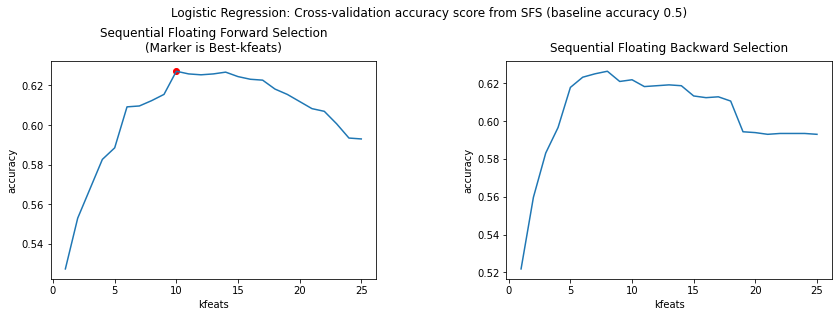

In [31]:
scor_fig

## Tune logistic regression penalty "C" (aka "alpha")

#### imports

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#### specify gridsearch and fit model

In [33]:
lr_simp = LogisticRegression(max_iter=10000)
Cs = np.logspace(-4,4,500)
pg = {'C': Cs}
grs = GridSearchCV(estimator=lr_simp, param_grid=pg)
# grs.fit(Xtr[sfs_feats_best], ytr);

#### pickle

In [34]:
# with open(path+'data/processed/grs.pickle','wb+') as f:
#     pickle.dump(grs, f)

with open(path+'data/processed/grs.pickle','rb') as f:
    grs = pickle.load(f)

#### extract C hyperparameters and cross-validation scores

In [35]:
C_scores = pd.Series(grs.cv_results_['mean_test_score'], index=grs.param_grid['C'])
C_scores_rolling = C_scores.rolling(10, center=True).mean()
best_C = C_scores_rolling.idxmax()
best_C_score = C_scores_rolling.max()

#### plot mean of cv splits for each candidate C

In [36]:
C_fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set_xscale('log')
ax.set_xlabel('C (Inverse Ridge Penalty)')
ax.set_ylabel('Mean Accuracy Score')
ax.set_title('Mean Accuracy Across CV Splits (Training Set)\n')
C_scores.plot(ax=ax)
C_fig.show()

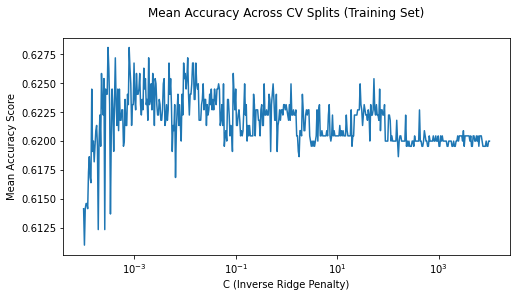

In [37]:
C_fig

#### plot rolling average of means over space of C values

In [38]:
C_rolling_fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.set_xscale('log')
ax.set_xlabel('C (Inverse Ridge Penalty)')
ax.set_ylabel('Rolling Mean Accuracy Score')
ax.set_title('Mean Accuracy Across CV Splits (Training Set)\n'
             '(Line is Rolling Average of Means, Marker is Best-C)')
C_scores_rolling.plot(ax=ax)
ax.scatter(x=best_C, y=best_C_score, marker='o', color=['r'])
C_rolling_fig.show()

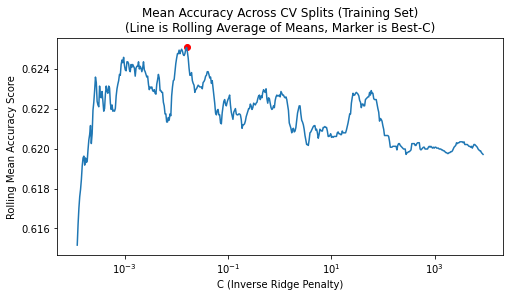

Best C is: 0.015717837177731626


In [39]:
display(C_rolling_fig)
print(f'Best C is: {best_C}')

## Test

In [40]:
lr_final = LogisticRegression(max_iter=10000, C=0.013)
lr_final.fit(Xtr[sfs_feats_best],ytr)
lr_final_accuracy_score = np.round(lr_final.score(Xte[sfs_feats_best],yte), 3)
lr_final_accuracy_score

0.615

# Results and Discussion

## Feature Selection

#### SFFS/SFBS from library "mlxtend" ([link](https://rasbt.github.io/mlxtend/))

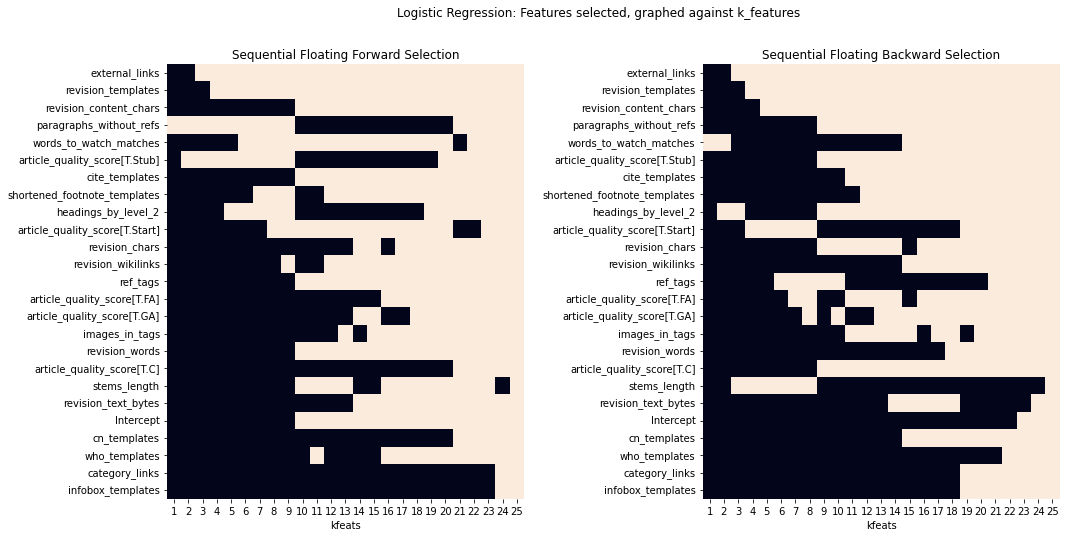

In [41]:
feat_fig

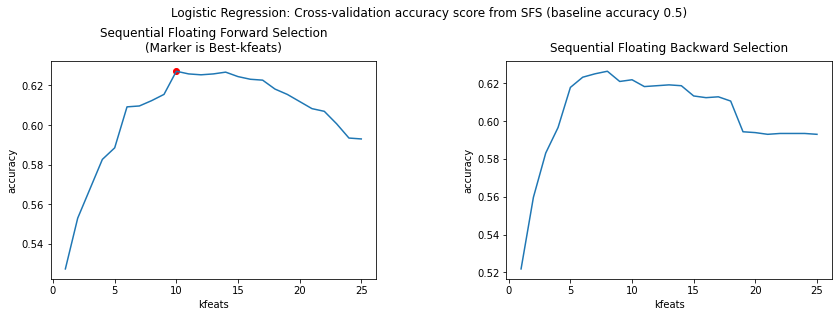

In [42]:
scor_fig

## Hyperparameter Tuning

#### For Logistic Regression (library scikit-learn), tuned the L2 Regularization Penalty C, where $C \equiv \frac{1}{\alpha}$


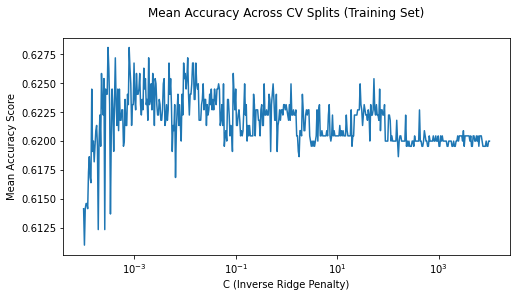

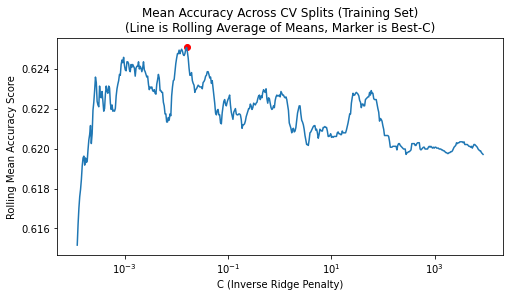

Best C is: 0.015717837177731626


In [43]:
display(C_fig, C_rolling_fig)
print(f'Best C is: {best_C}')

## Results

In [46]:
lr_final_accuracy_score 

0.615

(Baseline for accuracy is 0.5, as dataset is balanced.)

## Discussion

- Feature Selection
    - The 10-feature set had the best rolling-average mean cross-val score on the training set, out of all the the SFFS/SFBS sets.
    - A clear bias-variance trend is visible with both SFFS and SFBS methods.
    - Repeating/re-iterating the SFFS/SFBS feature selection with the optimal C (= 0.13) reaffirmed the optimal list of parameters.
- Hyperparameter tuning
    - A gridsearch over the logistic regression's regularization L2 penalty-weight parameter (C, aka alpha) found C=0.13 optimal.
    - While the validation curve for optimal C is not entirely concave-down with multiple local optima, an overall bias-variance trend is clearly visible.
    - The scale of the variability surrounding the optimal C is modest, with the maximum difference in accuracy well-under 1% within an order-of-magnitude of C's surrounding the optimal C.

## Conclusions and Next Steps

- The test score of 0.615 improved on the Logistic Regression test score from the regression in the original paper of 0.58.
- Some next steps are:
    - Present Confusion Matrix, ROC curve, F1 score, etc, to clarify results.
    - Apply XGBoost, to see if the SFFS/SFBS feature selection can improve on the author's XGBoost test score as well.
        - (Author's XGBoost score was 0.62)
    - Replicate the author's results while using the author's feature selection, to confirm the baseline.
    - Use NLP to improve the score.
    - Replicate the dataset generation process and use time-series article data to improve accuracy further.